<h1, align = "center"> Stock Price Prediction using Long-short term memory </h1>

<h3>_by Ann, Gunjan and Divya_ / [Github](https://github.com/NEU-BDIA-ADG/Stock_Market_Prediction-using-LSTM)</h3>


<h3> Introduction </h3>

Stock prices are totally random and unpredictable. It has attracted many attentions from academic as well as business. However, it is a challenging research topic, in which many advanced computational methods have been proposed, but not yet attained a desirable and reliable performance. 

Hence we decided on trying a model that predicts next day **_open price_** for a given single company name. The best feature in this project is the usuage of Long-short term memory for the prediction. Why LSTM ?

* RNN‟s (LSTM‟s) are pretty good at extracting patterns in input feature space, where the input data spans over long sequences 

* It can almost seamlessly model problems with multiple input variables (but the input need to be transformed to 3D input vector) 

* The other best feature is its flexibility to use several combinations of seq2seq LSTM models to forecast time-series: many to one model (useful when we want to predict at the current timestep given all the previous inputs), many to many model (useful when we want to predict multiple future time steps at once given all the previous inputs) and several other variations

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn. All recurrent neural networks have the form of a chain of repeating modules of neural network. LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.

**<H4, align = "center"><u> The repeating module in an LSTM contains four interacting layers</u></h4>**

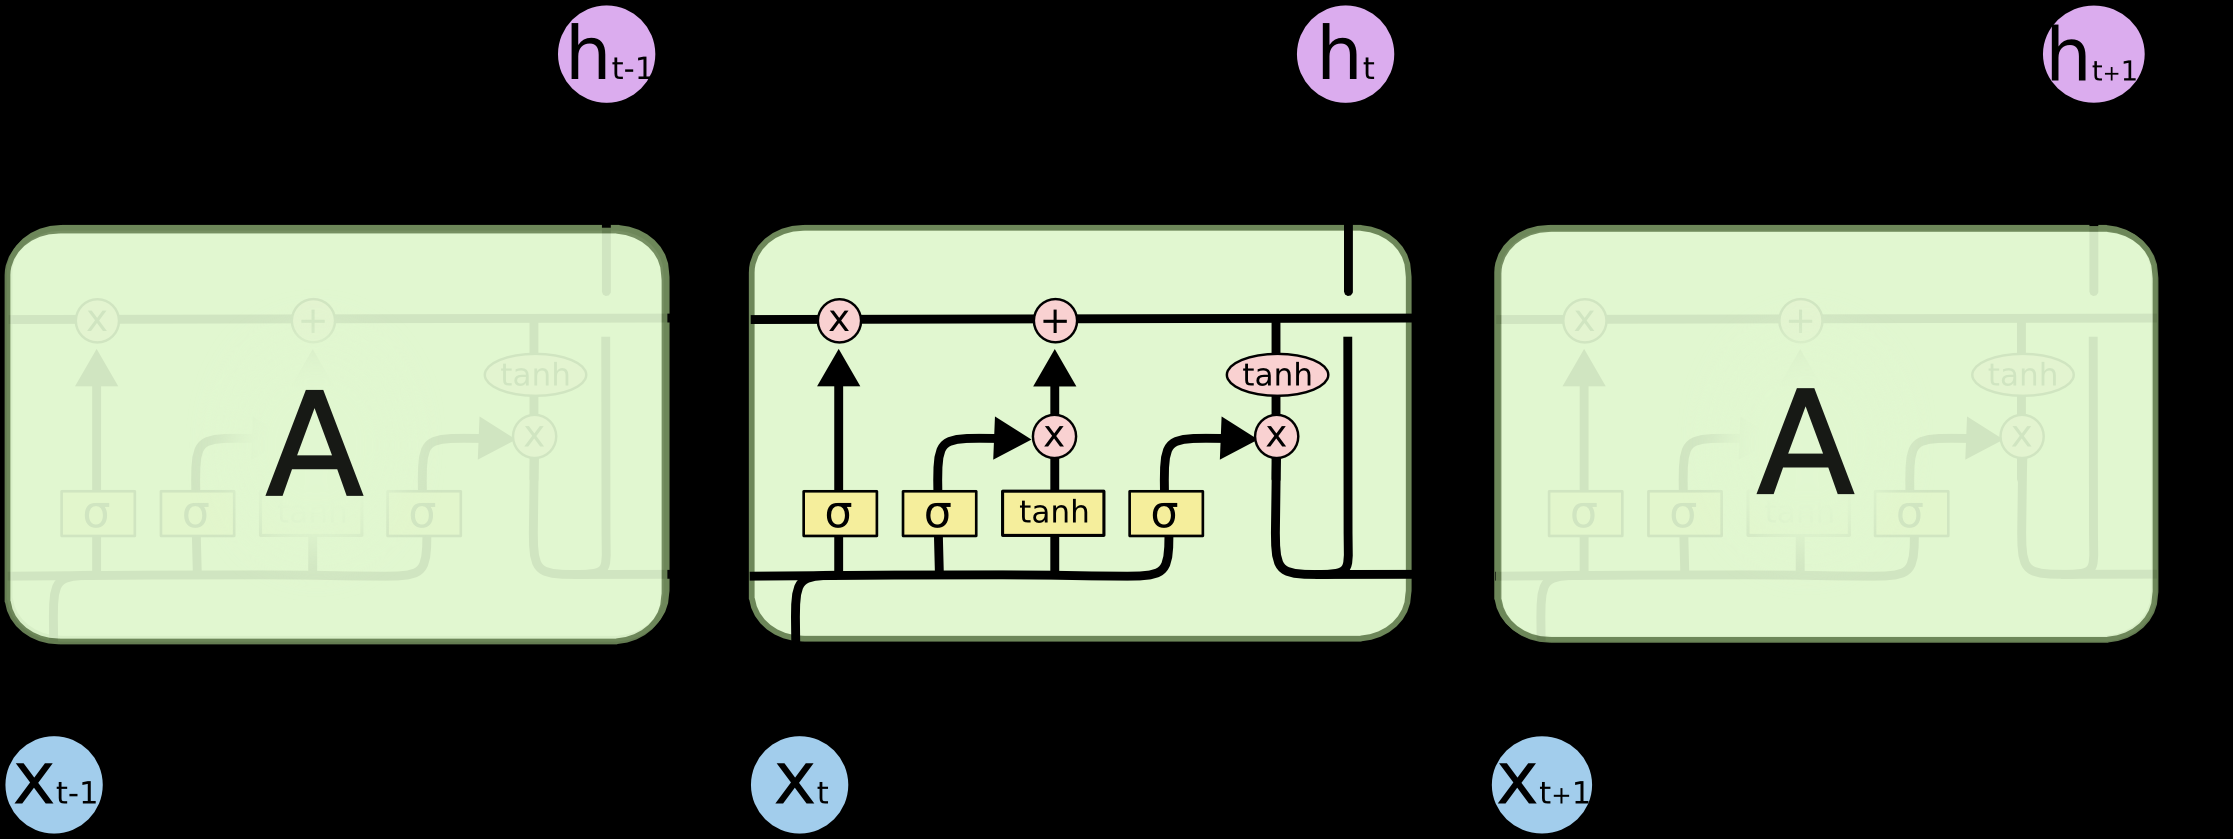

The key to LSTMs is the cell state.The cell state is kind of like a conveyor belt. It runs straight down the entire chain, with only some minor linear interactions. The LSTM does have the ability to remove or add information to the cell state, carefully regulated by structures called gates.Gates are a way to optionally let information through. They are composed out of a sigmoid neural net layer and a pointwise multiplication operation. The sigmoid layer outputs numbers between zero and one, describing how much of each component should be let through.

LSTMs were a big step in what we can accomplish with RNNs. And in our project we were able to implement with **73%** on predicting the open price. Inorder to build LSTM we have using keras with tensorflow as backend.

Below we import the required libraries for our model design.

In [1]:
import csv
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from numpy import concatenate
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
from sklearn.metrics import *
from math import sqrt
import time
import math
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
from matplotlib.dates import DateFormatter, WeekdayLocator,DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
import plotly
from datetime import date
import plotly.plotly as py
from plotly.tools import FigureFactory as FF
from datetime import datetime
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import urllib.request
import zipfile
from io import BytesIO
import os

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Data Ingestion

The stock data was uploaded into **amazon s3** inorder to make it independent of local system storage. Any one can retrive the data from Amazon s3 bucket **"bdia-data"** which is madde public.

In [2]:
df = pd.read_csv("APPLE_5years.csv")

In [15]:
url = urllib.request.urlopen("https://s3.amazonaws.com/bdia-data/AllData.zip")
f = zipfile.ZipFile(BytesIO(url.read()))
for item in f.namelist():
    print("File in zip: "+  item)
# find the first matching csv file in the zip:
match = [s for s in f.namelist() if ".csv" in s][0]

df = pd.read_csv(f.open(match), low_memory=False)

File in zip: AllModels/APPL_NoPrevOpenPrice.csv
File in zip: AllModels/APPL_PrevOpenPrice.csv
File in zip: AllModels/APPLE_5years.csv
File in zip: AllModels/APPLE_for_tweet.csv
File in zip: AllModels/SampleTweets.csv


We try to see the data distribution of the stock datat for 5 years. It seemed the data is symetric.

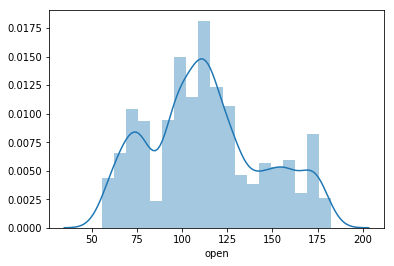

In [34]:
sns.distplot(df["open"])

Stock data is best described with "candle stick" plot. Hence we plotted it using ploty api. If we hover our pointer over the plot, it will give designated maximum, minimum, median and quartile value of a time of period. 

In [5]:
plotly.tools.set_credentials_file(username='DivyaEmmanuel', api_key='72YUEcZBuDiDZxHjAi7j')

In [12]:
fig = FF.create_candlestick(df.open, df.high, df.low, df.close, dates=df.index)
py.iplot(fig, validate=False)

In [30]:
df.head()

,date,close,volume,open,high,low
0,15:37,172.99,"27,398,212",174.8300,175.3900,172.6600
1,2018/04/18,177.84,20544600.0000,177.8100,178.8200,176.8800
2,2018/04/17,178.24,26575010.0000,176.4900,178.9365,176.4100
3,2018/04/16,175.82,21561320.0000,175.0301,176.1900,174.8301
4,2018/04/13,174.73,25100510.0000,174.7800,175.8400,173.8500


Removing the unwanted row from the dataset.

In [3]:
df = df.reset_index(drop=True)
df = df.drop(df.index[0])
df.head()

,date,close,volume,open,high,low
1,2018/04/18,177.84,20544600.0000,177.8100,178.8200,176.8800
2,2018/04/17,178.24,26575010.0000,176.4900,178.9365,176.4100
3,2018/04/16,175.82,21561320.0000,175.0301,176.1900,174.8301
4,2018/04/13,174.73,25100510.0000,174.7800,175.8400,173.8500
5,2018/04/12,174.14,22858840.0000,173.4100,175.0000,173.0400


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1260 entries, 1 to 1260
Data columns (total 6 columns):
date      1260 non-null object
close     1260 non-null float64
volume    1260 non-null object
open      1260 non-null float64
high      1260 non-null float64
low       1260 non-null float64
dtypes: float64(4), object(2)
memory usage: 68.9+ KB


### Feature Engineering

Making the **"date"** columns as index. Please note that we are creating and working with two different dataframes in this notebook.

"**df**"           : with previous day open price as one of the feature
"**df_nopreopen**" : without previous day open price as one of the feature

In [4]:
df['date'] = pd.to_datetime(df['date'])

df = df.set_index(['date'])
df_nopreopen = df
df.head()

,close,volume,open,high,low
date,,,,,
2018-04-18,177.84,20544600.0000,177.8100,178.8200,176.8800
2018-04-17,178.24,26575010.0000,176.4900,178.9365,176.4100
2018-04-16,175.82,21561320.0000,175.0301,176.1900,174.8301
2018-04-13,174.73,25100510.0000,174.7800,175.8400,173.8500
2018-04-12,174.14,22858840.0000,173.4100,175.0000,173.0400


The nice benefit of this capability is that if you are interested in looking at data summarized in a different time frame, just change the freq parameter to one of the valid offset aliases

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:


.resample() is now a deferred operation
You called plot(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead



Text(0.5,0,'Monthly frequency')

Text(0,0.5,'Close price')

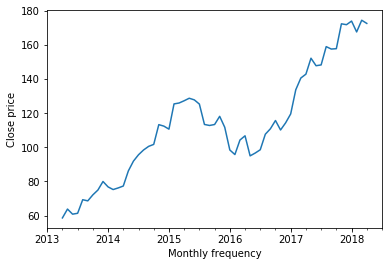

In [10]:
df.close.resample('M').plot()
plt.xlabel('Monthly frequency')
plt.ylabel('Close price')

We are rearranging the cloumns to bring the target file as the last cloumn.

In [33]:
arrange = df_nopreopen.columns.tolist()
arrange.remove('open')
arrange.append('open')
df_nopreopen = df_nopreopen[arrange]
df_nopreopen.head()

,close,volume,high,low,open
date,,,,,
2018-04-18,177.84,20544600.0000,178.8200,176.8800,177.8100
2018-04-17,178.24,26575010.0000,178.9365,176.4100,176.4900
2018-04-16,175.82,21561320.0000,176.1900,174.8301,175.0301
2018-04-13,174.73,25100510.0000,175.8400,173.8500,174.7800
2018-04-12,174.14,22858840.0000,175.0000,173.0400,173.4100


Since we are predicting next day open price. The target feature **"open"** values are shifted one row below. In the same way , for **df** dataframe the previous day open price feture is created by shifting the "**open**" column above one row for each value. 

In [8]:
df_nopreopen.open = df_nopreopen.open.shift(+1)

In [9]:
df = df.rename(columns={'open':'prevday_open'})
df['open'] = df['prevday_open']
df.prevday_open = df.prevday_open.shift(-1)
df.open = df.open.shift(+1)
df.head()

,close,volume,prevday_open,high,low,open
date,,,,,,
2018-04-18,177.84,20544600.0000,176.4900,178.8200,176.8800,NaN
2018-04-17,178.24,26575010.0000,175.0301,178.9365,176.4100,177.8100
2018-04-16,175.82,21561320.0000,174.7800,176.1900,174.8301,176.4900
2018-04-13,174.73,25100510.0000,173.4100,175.8400,173.8500,175.0301
2018-04-12,174.14,22858840.0000,172.2300,175.0000,173.0400,174.7800


We are searching if any null value present in the dataset before sending into the model.

In [10]:
print("For Dataset with Previous day Open price")
df.isnull().sum()
print("For Dataset with no Previous day Open price")
df_nopreopen.isnull().sum()

For Dataset with Previous day Open price


close           0
volume          0
prevday_open    1
high            0
low             0
open            1
dtype: int64

For Dataset with no Previous day Open price


close     0
volume    0
high      0
low       0
open      1
dtype: int64

As expected both dataset had null values. We are replacing the null values with mean of that particular column.

In [11]:
df = df.fillna(df.mean()['prevday_open'])
df = df.fillna(df.mean()['open'])
df_nopreopen = df_nopreopen.fillna(df_nopreopen.mean()['open'])
old_df = df
old_df_nopreopen = df_nopreopen

Now, this is the final shape of both dataset.

In [12]:
df.shape

(1260, 6)

In [13]:
df_nopreopen.shape

(1260, 5)

We are exporting the dataset as csv inorder to use them for other LSTM model.

In [30]:
df.to_csv("APPL_PrevOpenPrice.csv")
df_nopreopen.to_csv("APPL_NoPrevOpenPrice.csv")

### Prediction model - LSTM

Data cant be easily passed into LSTM model. It needs to undergo normalisation before passing, hence the each column has variant values. This will make the model inclined to features with high value.

In [14]:
from sklearn import preprocessing
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['close'] = min_max_scaler.fit_transform(df.close.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['prevday_open'] = min_max_scaler.fit_transform(df.prevday_open.values.reshape(-1,1))
    df['open'] = min_max_scaler.fit_transform(df['open'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning:

Data with input dtype object was converted to float64 by MinMaxScaler.



,close,volume,prevday_open,high,low,open
date,,,,,,
2018-04-18,0.969189,0.035588,0.952031,0.962979,0.973402,0.453699
2018-04-17,0.972366,0.059252,0.940551,0.963900,0.969648,0.962411
2018-04-16,0.953149,0.039577,0.938584,0.942174,0.957028,0.952031
2018-04-13,0.944493,0.053466,0.927811,0.939406,0.949200,0.940551
2018-04-12,0.939808,0.044669,0.918531,0.932761,0.942730,0.938584


In [15]:
def normalize_data_nopreopen(data):
    min_max_scaler = preprocessing.MinMaxScaler()
    data['close'] = min_max_scaler.fit_transform(data.close.values.reshape(-1,1))
    data['high'] = min_max_scaler.fit_transform(data.high.values.reshape(-1,1))
    data['low'] = min_max_scaler.fit_transform(data.low.values.reshape(-1,1))
    data['volume'] = min_max_scaler.fit_transform(data.volume.values.reshape(-1,1))
    data['open'] = min_max_scaler.fit_transform(data['open'].values.reshape(-1,1))
    return data
df_nopreopen = normalize_data_nopreopen(df_nopreopen)
df_nopreopen.head()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning:

Data with input dtype object was converted to float64 by MinMaxScaler.



,close,volume,high,low,open
date,,,,,
2018-04-18,0.969189,0.035588,0.962979,0.973402,0.454448
2018-04-17,0.972366,0.059252,0.963900,0.969648,0.962411
2018-04-16,0.953149,0.039577,0.942174,0.957028,0.952031
2018-04-13,0.944493,0.053466,0.939406,0.949200,0.940551
2018-04-12,0.939808,0.044669,0.932761,0.942730,0.938584


Now, We’ll start by transforming the dataset to the numpy array that will feed the LSTM. The way Keras LSTM layers work is by taking in a numpy array of 3 dimensions (N, W, F) where N is the number of training sequences, W is the sequence length and F is the number of features of each sequence. We chose to go with a sequence length (read window size) of 20 which allows for the network so get glimpses of the shape of the data at each sequence and hence will hopefully teach itself to build up a pattern of the sequences based on the prior window received. The sequences themselves are sliding windows and hence shift by 1 each time, causing a constant overlap with the prior windows.

In [16]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

Lstm model is build with drop out as 0.3. Dropout is a regularization technique for neural network models proposed by Srivastava, et al. in their 2014 paper Dropout: A Simple Way to Prevent Neural Networks from Overfitting. It is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. 

Below is the architecture of our LSTM model:
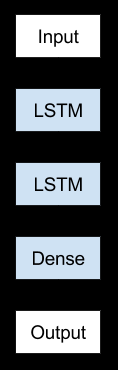



In [17]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

Splitting the data into test and train for both dataframe simultaneously

In [18]:
window = 20
X_train, y_train, X_test, y_test = load_data(df, window)
X_train1, y_train1, X_test1, y_test1 = load_data(df_nopreopen, window)
print (X_train[0], y_train[0])

[[0.96918923 0.03558765 0.95203109 0.96297887 0.97340164 0.45369907]
 [0.9723656  0.0592524  0.94055079 0.96390044 0.96964752 0.96241125]
 [0.95314857 0.0395775  0.93858407 0.94217426 0.95702808 0.95203109]
 [0.94449297 0.05346612 0.92781072 0.93940559 0.94919953 0.94055079]
 [0.93980783 0.04466927 0.91853149 0.93276077 0.94272966 0.93858407]
 [0.92630827 0.04287276 0.92458658 0.92424275 0.93202642 0.92781072]
 [0.93274041 0.06706987 0.90005166 0.92485027 0.93066855 0.91853149]
 [0.90732947 0.06867524 0.90862316 0.91765172 0.91720962 0.92458658]
 [0.89406813 0.09211663 0.92128381 0.91282632 0.90407019 0.90005166]
 [0.929167   0.05994012 0.86073289 0.92667285 0.93506167 0.90862316]
 [0.9197173  0.09067314 0.88243685 0.90910838 0.87667308 0.92128381]
 [0.89414754 0.07362543 0.88432415 0.88328457 0.87755171 0.86073289]
 [0.88056857 0.10183284 0.88373437 0.88482316 0.87427683 0.88243685]
 [0.88930358 0.10454312 0.87936999 0.90705165 0.89368644 0.88432415]
 [0.87898039 0.11768378 0.92993394

In [19]:
model = build_model([6,window,1])
model1 = build_model([5,window,1])

Compilation Time :  0.015626192092895508
Compilation Time :  0.01566338539123535


Fitting the model with 100 epochs. We tried the model with 10,30,80,100,150,200 epochs but founf 100 giving the best result for our dataset.

In [20]:
model.fit(X_train,y_train,batch_size=512,epochs=100,validation_split=0.1,verbose=1)

Train on 1003 samples, validate on 112 samples
Epoch 1/100
1003/1003 [==============================] - 3s 3ms/step - loss: 0.3092 - acc: 0.0000e+00 - val_loss: 0.0234 - val_acc: 0.0000e+00
Epoch 2/100
1003/1003 [==============================] - 2s 2ms/step - loss: 0.2588 - acc: 0.0000e+00 - val_loss: 0.0111 - val_acc: 0.0000e+00
Epoch 3/100
1003/1003 [==============================] - 2s 2ms/step - loss: 0.1208 - acc: 0.0000e+00 - val_loss: 0.0326 - val_acc: 0.0000e+00
Epoch 4/100
1003/1003 [==============================] - 2s 2ms/step - loss: 0.0418 - acc: 9.9701e-04 - val_loss: 0.2397 - val_acc: 0.0000e+00
Epoch 5/100
1003/1003 [==============================] - 2s 2ms/step - loss: 0.0683 - acc: 9.9701e-04 - val_loss: 0.1868 - val_acc: 0.0000e+00
Epoch 6/100
1003/1003 [==============================] - 2s 2ms/step - loss: 0.0443 - acc: 9.9701e-04 - val_loss: 0.1069 - val_acc: 0.0000e+00
Epoch 7/100
1003/1003 [==============================] - 2s 2ms/step - loss: 0.0414 - acc: 0.00

In [41]:
model1.fit(X_train1,y_train1,batch_size=512,epochs=100,validation_split=0.1,verbose=1)

Train on 1003 samples, validate on 112 samples
Epoch 1/100
1003/1003 [==============================] - 4s 4ms/step - loss: 0.3053 - acc: 0.0000e+00 - val_loss: 0.0219 - val_acc: 0.0000e+00
Epoch 2/100
1003/1003 [==============================] - 3s 3ms/step - loss: 0.2413 - acc: 0.0000e+00 - val_loss: 0.0071 - val_acc: 0.0000e+00
Epoch 3/100
1003/1003 [==============================] - 2s 2ms/step - loss: 0.0836 - acc: 0.0000e+00 - val_loss: 0.0864 - val_acc: 0.0000e+00
Epoch 4/100
1003/1003 [==============================] - 2s 2ms/step - loss: 0.0598 - acc: 9.9701e-04 - val_loss: 0.2053 - val_acc: 0.0000e+00
Epoch 5/100
1003/1003 [==============================] - 2s 2ms/step - loss: 0.0591 - acc: 9.9701e-04 - val_loss: 0.1155 - val_acc: 0.0000e+00
Epoch 6/100
1003/1003 [==============================] - 2s 2ms/step - loss: 0.0371 - acc: 9.9701e-04 - val_loss: 0.0595 - val_acc: 0.0000e+00
Epoch 7/100
1003/1003 [==============================] - 3s 3ms/step - loss: 0.0454 - acc: 0.00

Predicting the target value for both dataset

In [21]:
p = model.predict(X_test)
p1 = model1.predict(X_test1)

Calculaying the RMSE value for both dataset.

In [43]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

print("--- With Previous day open price ----")
model_score(model, X_train, y_train, X_test, y_test)
print("--- Without Previous day open price ----")
model_score(model1, X_train1, y_train1, X_test1, y_test1)

--- With Previous day open price ----
Train Score: 0.00063 MSE (0.03 RMSE)
Test Score: 0.00031 MSE (0.02 RMSE)


(0.0006310450083851781, 0.00031474417905443376)

--- Without Previous day open price ----
Train Score: 0.00085 MSE (0.03 RMSE)
Test Score: 0.00038 MSE (0.02 RMSE)


(0.000849009821290096, 0.0003821141454541395)

Eevn now the values predicted are normalised. Hence , we are denormalising the same before exposing the result.

In [44]:
# Bug fixed at here, please update the denormalize function to this one
def denormalize(df, normalized_value): 
    df = df['open'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(old_df, p)
newy_test = denormalize(old_df, y_test)
newp1= denormalize(old_df_nopreopen,p1)
newy_test1 =denormalize(old_df_nopreopen,y_test1)

### Error metrics for Dataset with "Previous day open price" as one of the feature

This is the dataset with extra feature. And the one that is better than any moedl we trained.

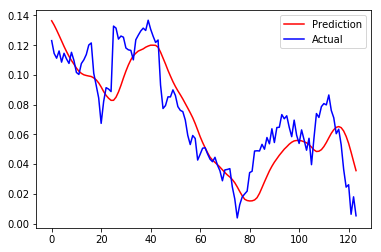

In [45]:

plt.plot(newp,color='red', label='Prediction')
plt.plot(newy_test,color='blue', label='Actual')
plt.legend(loc='best')

plt.show()

In [46]:
summary_test = pd.DataFrame(index={'MAE', 'MAPE', 'RMSE', 'R2'})
def determineAnalysis(true, pred, regressor): 
    mae = mean_absolute_error(true, pred)
    rmse = sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    true, pred = np.array(true), np.array(pred)
    mape = np.mean(np.abs((true - pred) / true)) * 100
    print('Mean absolute error is ',mae)
    print('Mean absolute percentage error is ',mape)
    print('Root mean squared error is ',rmse)
    print('RSquare is ',r2)
    return mae,mape,rmse,r2

mae,mape,rmse,r2 = determineAnalysis(newy_test, newp, model)

Mean absolute error is  0.014102523969083703
Mean absolute percentage error is  36.40292827065579
Root mean squared error is  0.017741031089775806
RSquare is  0.7394083360826034


### Error metrics for Dataset without "Previous day open price" as one of the feature

This is the dataset exclusing the extra feature. This model have 10% lesss accuracy than the one with extra feature.

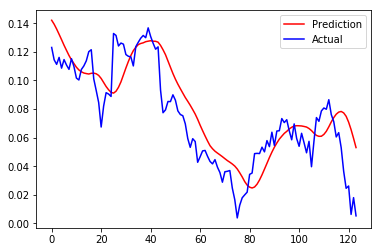

In [47]:
plt.plot(newp1,color='red', label='Prediction')
plt.plot(newy_test1,color='blue', label='Actual')
plt.legend(loc='best')

plt.show()

In [48]:
mae,mape,rmse,r2 = determineAnalysis(newy_test1, newp1, model1)

Mean absolute error is  0.01552882849777926
Mean absolute percentage error is  50.25538438805084
Root mean squared error is  0.01954774002360458
RSquare is  0.6836295487630801


In order to serialize the model pickling the file is one of the best way. But for model build using kersas it is not recommended. Hence we use **model.save(filepath)** to save a Keras model into a single HDF5 file which will contain:

* the architecture of the model, allowing to re-create the model
* the weights of the model
* the training configuration (loss, optimizer)
* the state of the optimizer, allowing to resume training exactly where you left off


The best obtained model is than saved in order to predict values with out rerunning the entier model.

In [25]:
from keras.models import load_model

model.save('my_model.h5')

After saving the LSTM model, we tried building another LSTM model that takes senitment measures from twitter api as one of the feature. Please refer this notebook for LSTM with sentiment meassures : [LSTM_with tweets.ipynb](https://github.com/NEU-BDIA-ADG/Stock_Market_Prediction-using-LSTM/blob/master/BDIA%20Project/LSTM_with%20tweets.ipynb)

Result of the model with tweet sentiment measures along with previous open price :
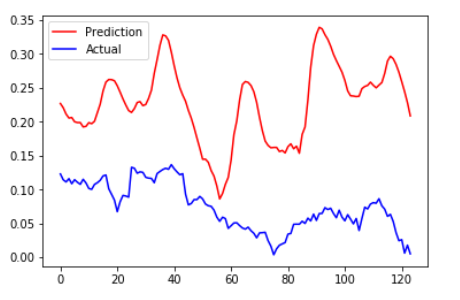

and the error metrics are:
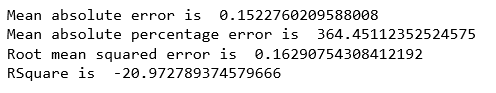

Result of the model with tweet sentiment measures :
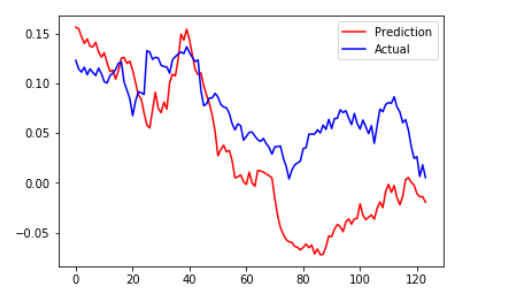

and the error metrics are:
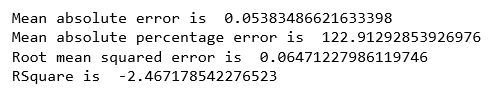

The above results were worst as expected since the stock prediction cant be relied on randomn tweets by any user. The impact is different when a celebrity or a famous personality tweets. But None of them tweet daily about stocks. 

Since ARIMA models are most recommended for time series forcasting, we tried passing the same dataset for the model ended up [ARIMA_Model_with_5years.ipynb](https://github.com/NEU-BDIA-ADG/Stock_Market_Prediction-using-LSTM/blob/master/BDIA%20Project/Arima_Model_with_5years.ipynb) , [ARIMA_Model_No_previous.ipynb](https://github.com/NEU-BDIA-ADG/Stock_Market_Prediction-using-LSTM/blob/master/BDIA%20Project/Arima_model_No_previous.ipynb)  and   [ARIMA_Model_with_previous_Open](https://github.com/NEU-BDIA-ADG/Stock_Market_Prediction-using-LSTM/blob/master/BDIA%20Project/Arima_model_with_previous_Open.ipynb).

Even ARIMA model wasnt able to give proper result for the dataset created by us.

Error metric for data pulled stock data websites:
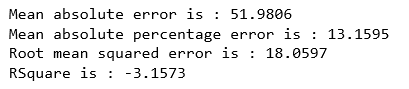

Error metric for data with twitter measures and previous day open prices:
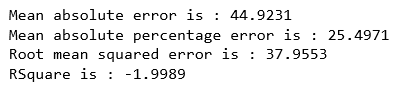

Error metric for data with twitter measures:
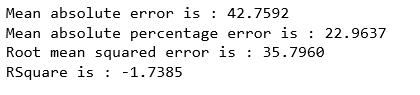

<h2> Conclusion :</h2>

After analysing , the model with dataset that had extra feature was considered best after various tunning of hyperparameters. We took the same dataset along with tweeter sentiment measure but the model responded with bad results. Extracting tweets randomnly for a single day will not have much difference or any impact on a stock price of a company on any given day. As it was discussed earlier, stock price rise and fall is randomn. It might or might not includes environment changes, sudden breaking news, unexpected statement from a famouse personality or even might be a weather climate change. Hence , we conclude that Stock prediction is not as easy as predicting any other data. It requires lot of data which might not even directly be relevant to it. The model will give better result if any further more features has been added as its predictor.

**Note : Local web application created with LSTM model with UI interface.**

 #### References :
 [1] Sreelekshmy Selvin, Vinayakumar R,Gopalakrishnan E.A, Vijay Krishna Menon, Soman K.P. “Stock Price
Prediction using LSTM,RNN and CNN-sliding window model”. IEEE(2017): 1643-1647

[2] Jiahong Li, Hui Bu*, Junjie Wu. “Sentiment-Aware Stock Market Prediction: A Deep Learning Method”.
National Natural Science Foundation of China (71471009,71531001, 71373001, 71671012)

[3] Lee, Wayne Y., Christine X. Jiang, and Daniel C. Indro. "Stock market volatility, excess returns, and the role of investor sentiment." Journal of banking & Finance 26.12 (2002): 2277-2299.

[4] Baker, Malcolm, and Jeffrey Wurgler. "InvestoR sentiment and the cross‐section of stock returns." The Journal of Finance 61.4 (2006): 1645-1680.

[5]http://colah.github.io/posts/2015-08Understanding-LSTMs/

[6]http://www.jakobaungiers.com/articles/a/LSTMNeural-Network-for-Time-Series-Prediction

[7]https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7995302

[8]https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8256643&tag=1

#### Licensing:

The text in the document by Ann Sara Sajee, Gunjan Lalwani, Divya Priya Emmanuel is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/

The text in the document by Ann Sara Sajee, Gunjan Lalwani, Divya Priya Emmanuel is licensed under the MIT License https://opensource.org/licenses/MIT